In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import flamedisx as fd

# Flamedisx tutorial

Flamedisx is a package for inference on Liquid Xenon TPC data. This tutorial assumes you are familiar with these detectors, and we will not attempt to explain jargon like S1, S2, etc.

## 1. Simulation

Before we can do anything, we have to load some data. If you don't have a LXe TPC handy, flamedisx can simulate some data for you.

In [2]:
df = fd.ERSource.simulate(1000)
df.head()

,r,theta,x,y,z,drift_time,s1,s2,photon_detection_eff,photon_gain_mean,...,photon_produced_min,photon_detected_max,photon_produced_max,electron_produced_mle,electron_detected_min,electron_produced_min,electron_detected_max,electron_produced_max,nq_min,nq_max
567,4.695303,0.292757,4.495526,1.355033,-94.275415,706182.884909,9.752324,573.242969,0.1,1.0,...,3,14,181,142,25,55,33,229,58,410
392,2.958197,0.233758,2.877742,0.685222,-77.590520,581202.393617,58.017769,971.160551,0.1,1.0,...,253,62,697,182,43,98,54,266,351,963
318,3.943998,0.786515,2.785712,2.791940,-82.937636,621255.701929,25.177361,850.750914,0.1,1.0,...,54,30,358,175,38,88,47,262,142,620
394,6.111253,0.403735,5.619909,2.400840,-27.259507,204191.063374,23.485260,1826.236350,0.1,1.0,...,45,28,339,149,84,100,98,198,145,537
90,4.900989,0.769826,3.519064,3.411140,-94.545134,708203.252679,10.363776,332.252162,0.1,1.0,...,3,15,189,82,14,13,20,151,16,340


Here we used the default `ERSource`, which describes a flat-spectrum ER source (with some cutoffs) homogeneously distributed in the TPC. 

Flamedisx has other `Source` classes for different populations. You usually want to define your own `Source`s. We'll discuss this later below.

As you can see, the data is a Pandas dataframe. The first columns are direct observables, such as the $x$ position in cm and the $s1$ size in PE. The other columns are derived observables and truth info from the flamedisx simulator, which we can ignore for now.

Let's plot the data:

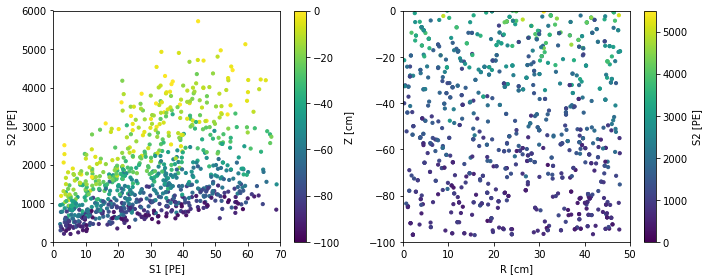

In [3]:
def scatter_2x2d(df, s=10, color_by=None, color_label=None, vmin=None, vmax=None, **kwargs):
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    if color_by is None:
        c = df['z']
        vmin, vmax = -100, 0
    else:
        c = color_by
        
    plt.sca(axes[0])
    plt.scatter(df['s1'], df['s2'], s=s, c=c, vmin=vmin, vmax=vmax, **kwargs)
    plt.colorbar(label='Z [cm]' if color_by is None else color_label)
    plt.xlim(0, 70)
    plt.ylim(0, None)
    plt.xlabel("S1 [PE]")
    plt.ylabel("S2 [PE]")

    if color_by is None:
        c = df['s2']
        vmin, vmax = 0, 5500
    else:
        c = color_by
        
    plt.sca(axes[1])
    plt.scatter(df['r']**2, df['z'], c=c, s=s, vmin=vmin, vmax=vmax, **kwargs)
    plt.colorbar(label='S2 [PE]' if color_by is None else color_label)
    plt.xlabel("R [cm]")
    plt.xlim(0, 50)
    plt.ylim(-100, 0)

    plt.tight_layout()
    
scatter_2x2d(df)

We asked flamedisx for 1000 events, but we actually got back a few less:

In [4]:
len(df)

835

This is because the `Source` includes models for some basic cuts. If you're curious, the default source cuts events with less than 3 photons detected, S1 outside [2, 70] PE, or S2 outside [200, 5000] PE.

You can also simulate events at specific energies, e.g. at 5 keV:

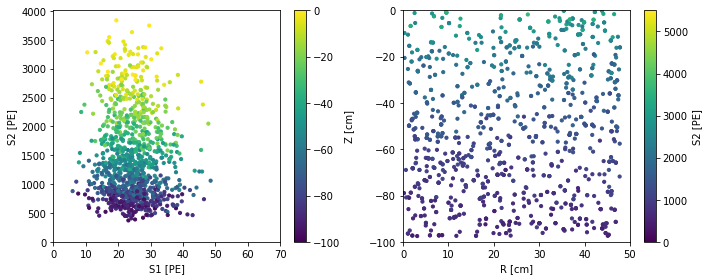

In [5]:
scatter_2x2d(
    fd.ERSource.simulate(5. * np.ones(1000)))

Finally, you can use another dataset to draw the auxiliary observables from -- anything besides s1 and s2, i.e. x, y, z, drift time, and (for custom sources) other things you might like. For example, here we simulate events at the same position as the first event in df:

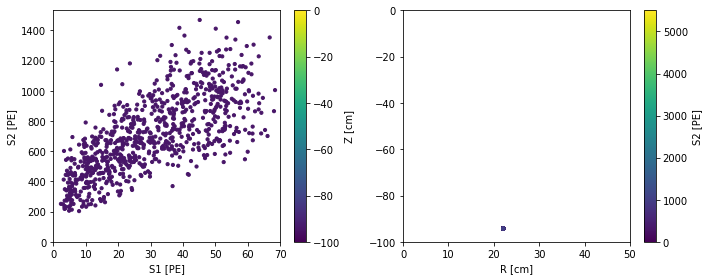

In [6]:
scatter_2x2d(
    fd.ERSource.simulate(1000, data=df[:1]))

## 2. Inference

For this tutorial, let's just fit something easy: the electron lifetime (elife). To ensure the fit goes fast even if you don't have a GPU available, we simulate just 25 events as the dataset. The 'true' elife used to generate this is 452 us. 

In [7]:
smalld = fd.ERSource.simulate(25)

Flamedisx computes the **differential rate** at each event analytically:

\begin{equation}
\mu \times \text{PDF}(\mathrm{S1}, \mathrm{S2}, x, y, z, \ldots)
\end{equation}

where $\mu$ is the total expected number of events from the source.

You rarely need to do this yourself, but let's do it anyway, for two electron lifetimes:

100%|██████████| 2/2 [00:06<00:00,  3.79s/it]


Electron lifetime = 100 us


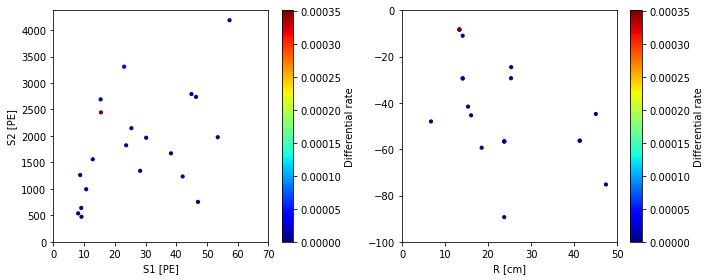

100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Electron lifetime = 500 us


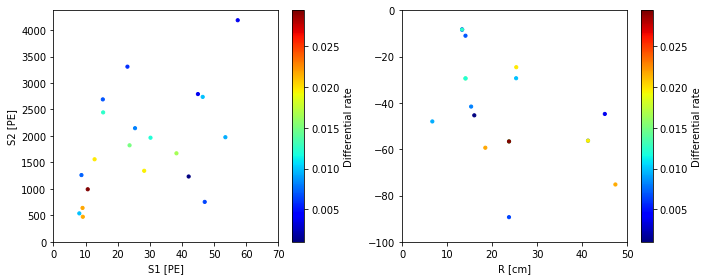

In [8]:
source = fd.ERSource(smalld)

for elife_us in (100, 500):
    diffrate = source.batched_differential_rate(elife=elife_us * 1e3)
    print("Electron lifetime = %d us" % elife_us)
    scatter_2x2d(smalld, color_by=diffrate, color_label='Differential rate', cmap=plt.cm.jet)
    plt.show()

Notice the differential rates are very low for elife = 100 us. Flamedisx correctly computed that all the events would  have to be extreme outliers if elife = 100 us were true. At 500 us, the rates are clearly higher, indicating the events wouldn't be so unusual at this elife.

Looking directly at differential rates is  no way to do inference, you want an extended unbinned log likelihood to do this for you. For a single source, the formula is:
\begin{equation}
\log L = - \mu + \sum_\mathrm{events} \mu \times \text{PDF at the event}
\end{equation}
where $\mu$ is the expected number of events from the source (after all selections). The term inside the sum is the differential rate, which we've already seen that flamedisx can compute. For the first term $\mu$, it still needs simulations at some " anchor points" -- reference parameter space values between it interpolates.

Flamedisx likelihoods are made with the `LogLikelihood` class:

In [9]:
ll = fd.LogLikelihood(
    # Dictionary of sources to use. 
    # Use multiple sources if your signal/background model has more than one component
    sources=dict(er=fd.ERSource),
    # Data to use:
    data=smalld,
    # Parameters to fit, with (lower anchor, upper anchor, number of anchor points):
    elife=(300e3, 500e3, 3),
    # Allow the absolute ER rate to be fitted as well
    free_rates=('er',))

Estimating mus: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


You can get the best fit with the `bestfit`. Guesses are passed with the `guess` argument. To convert the bestfit to human-readable form, pass it to summary.

It's a good idea to pass decent guesses. If you don't pass any guesses, well, it will just guess something, depending on the defaults specified in the source. These might be bad and cause the optimizer to fail.


In [10]:
%%time
bestfit = ll.bestfit(guess=dict(er_rate_multiplier=0.03, elife=400e3))
ll.summary(bestfit)

W0723 18:32:50.637724 140284825524032 deprecation.py:323] From /home/jelle/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow_probability-0.7.0rc0-py3.7.egg/tensorflow_probability/python/math/interpolation.py:126: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


er_rate_multiplier: 0.0236 +- 0.00372
elife: 4.49e+05 +- 1.98e+04
Correlation matrix:
                    er_rate_multiplier      elife
er_rate_multiplier           1.000e+00  2.803e-04
elife                        2.803e-04  1.000e+00
CPU times: user 33.7 s, sys: 353 ms, total: 34.1 s
Wall time: 14.6 s


The best-fit value depends on the simulated data, which varies each time you run the notebook. However, it should be within +- 10 us of the true value, 452 us. This looks pretty amazing for just 50 events, but of course the ER model is here assumed completely known in all other respects, which is unrealistic.

The errors and covariances are computed from the inverse of the Hessian (matrix of second derivatives). These are like the HESSE errors from migrad. You can get the inverse hessian yourself if you want|:

In [11]:
inv_h = ll.inverse_hessian(bestfit)
np.diag(inv_h)**0.5

array([3.7242856e-03, 1.9806797e+04], dtype=float32)

If you already computed the Hessian, you can pass it to `summary` so it doesn't have to do it again. It will run almost instantly in that case.

In [12]:
ll.summary(bestfit, inverse_hessian=inv_h)

er_rate_multiplier: 0.0236 +- 0.00372
elife: 4.49e+05 +- 1.98e+04
Correlation matrix:
                    er_rate_multiplier      elife
er_rate_multiplier           1.000e+00  2.803e-04
elife                        2.803e-04  1.000e+00


## 3. Modelling

To do any serious work, you have to define custom sources. This means defining a class which inherits from one of the basic two flamedisx sources (ERSource or NRSource) and overrides one or more of the **model functions**. Here is the complete list of things you can override:

In [13]:
sorted(fd.source.data_methods)

['double_pe_fraction',
 'electron_acceptance',
 'electron_detection_eff',
 'electron_gain_mean',
 'electron_gain_std',
 'energy_spectrum',
 'p_electron',
 'p_electron_fluctuation',
 'penning_quenching_eff',
 'photon_acceptance',
 'photon_detection_eff',
 'photon_gain_mean',
 'photon_gain_std',
 's1_acceptance',
 's2_acceptance',
 'work']

Each of these can be specified as either a constant or a function. The function can take any **observable** (such as x or drift_time) as a positional argument and any **parameters** (something you can fit, e.g. elife) as keyword arguments.

Here's an example: a source that parametrizes the loss of electrons during drift via the electron **absorption_length** (in cm) rather than elife:

In [14]:
import tensorflow as tf

class CustomERSource(fd.ERSource):
    
    # staticmethod just means: don't take self as an argument
    @staticmethod   
    def electron_detection_eff(z, absorption_length=60):
        # Note z is negative, and in cm
        return tf.exp(z / absorption_length)     


Note that we have to use tensorflow inside the model functions. If you keep it (very) simple, you can just replace np -> tf. Or, of course, you can learn tensorflow.

We can fit this as before:

In [15]:
ll2 = fd.LogLikelihood(
    sources=dict(er=CustomERSource),
    data=smalld,
    absorption_length=(20., 100., 3),
    free_rates=('er',))

Estimating mus: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


In [16]:
%%time
bf2 = ll2.bestfit(guess=dict(er_rate_multiplier=0.03))
ll2.summary(bf2)

er_rate_multiplier: 0.0243 +- 0.00387
absorption_length: 55.7 +- 2.21
Correlation matrix:
                    er_rate_multiplier  absorption_length
er_rate_multiplier               1.000             -0.103
absorption_length               -0.103              1.000
CPU times: user 26.7 s, sys: 241 ms, total: 27 s
Wall time: 13 s


The result will be around 60 cm (+- 1.5 cm or so), which is the true value consistent with our our 452 us elife:

In [17]:
452e3 * fd.ERSource.drift_velocity

60.342

## 4. Modelling 2

Let's try to fit a more complex part of the ER model. In particular, let's find `p_electron`, the **fraction of detected quanta that are electrons** as a function of energy. This is equivalent to the charge yield Q_y (given a work function), and encodes all effects of exciton/ion splitting and recombination.

Here's a source implementation that achieves this:

In [18]:
class MyERSource(fd.ERSource):

    @staticmethod
    #def p_electron(nq, a=0.2, b=-0.38, c=0.45, nq0=365):
    def p_electron(nq, a=0.1, b=-0.25, c=0.40, nq0=365):
        x = fd.tf_log10(nq / nq0 + 1e-9)
        return fd.safe_p(a * x**2 + b * x + c)

Note:
  * The `p_electron` takes an additional argument `nq`, the number of produced quanta. This is not an observable, but a 'hidden variable' of the process, just like e.g. energy or the number of produced photons. In flamedisx you have complete freedom to make any model function depend on any observable you like, but you cannot add dependencies on hidden variables. Such changes would require changes in the flamedisx core code.
  * fd.tf_log10 is a shortcut to tensorflow implementation of log10 (the base-10 logarithm)
  * fd.safe_p clips the values to just above 0 and just below 1.
  
Let's fit it, along with a few other parameters that could be a cause for uncertainty such as elife and g2:

In [19]:
ll3 = fd.LogLikelihood(
    sources=dict(er=MyERSource),
    data=smalld,
    a=(0.1, 0.5, 3),
    b=(-0.5, -0.2, 3),
    c=(0.35, 0.45, 3),
    elife=(400e3, 500e3, 3),
    g2=(25., 35., 3),
    free_rates=('er',))

Estimating mus: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Notice the mu estimation took a bit longer, because we have more parameters to fit. However, this scales linearly with the number of parameters and anchor points. This is because we assume the effects of each parameter (except the rate multipliers) on $\mu$ are small, so we can add them linearly. For most parameters this is quite accurate, especially if you have a decent amount of data.

In [20]:
%%time
bf3 = ll3.bestfit(guess=dict(er_rate_multiplier=0.03))
ll3.summary(bf3)

er_rate_multiplier: 0.0238 +- 0.0038
a: 0.101 +- 0.273
b: -0.41 +- 0.0592
c: 0.489 +- 0.021
elife: 3.96e+05 +- 2.54e+04
g2: 20.2 +- 0.585
Correlation matrix:
                    er_rate_multiplier      a      b      c  elife     g2
er_rate_multiplier               1.000  0.096 -0.075 -0.011 -0.039  0.004
a                                0.096  1.000  0.123 -0.365 -0.283  0.027
b                               -0.075  0.123  1.000 -0.323  0.094 -0.009
c                               -0.011 -0.365 -0.323  1.000 -0.490 -0.327
elife                           -0.039 -0.283  0.094 -0.490  1.000 -0.181
g2                               0.004  0.027 -0.009 -0.327 -0.181  1.000
CPU times: user 2min 18s, sys: 1.66 s, total: 2min 19s
Wall time: 52 s


The fit took ~4x as long, because it had a bigger parameter space to explore -- 6D vs. 2D. Things could have been much, much worse. As our likelihood is differentiable, we could give the minimizer a gradient. This told it in which direction to go -- quite useful if you are lost in six dimensions!

Finally, let's compare the p_electron function we ust fitted with the ground truth -- that is, the ones the data was simulated with:

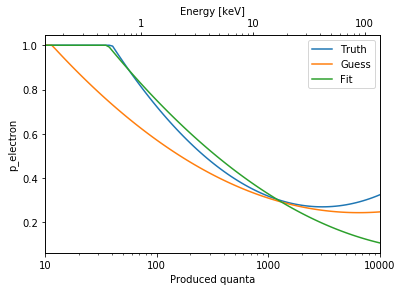

In [21]:
def plot_nq(s_class=fd.ERSource, plot_kwargs=None, twin=True, 
            # Eat params we don't need...
            er_rate_multiplier=None, elife=None, g2=None,
            **params):
    if plot_kwargs is None:
        plot_kwargs = dict()
    nq = np.logspace(1, 4, 100)
    
    plt.plot(nq, s_class.p_electron(nq, **params), **plot_kwargs)
    plt.xlabel('Produced quanta')
    plt.ylabel('p_electron')
    plt.xlim(10, 1e4)
    plt.xscale('log')
    ax = plt.gca()
    
    if twin:
        ax2 = plt.twiny()
        ax2.set_xscale('log')
        ax2.set_xlim(*np.array(ax.get_xlim()) * fd.ERSource.work)
        ax2.set_xlabel("Energy [keV]")

    for x in [ax] + ([ax2] if twin else []):
        x.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.sca(ax)
        
plot_nq(plot_kwargs=dict(label='Truth'))
plot_nq(MyERSource,  plot_kwargs=dict(label='Guess'), twin=False)
plot_nq(MyERSource,  plot_kwargs=dict(label='Fit'), twin=False, **ll3.params_to_dict(bf3))
plt.legend(loc='upper right')

It seems we actually fitted something! The fit is poor at high energy, because or data does not reach so far.

## 5. Why bother with high-dimensional likelihoods?

Let's draw some mock ER data with a poor electron lifetime of 200 us -- you'll see why in a moment. 

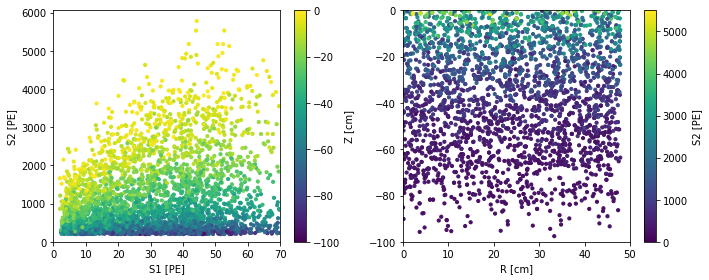

In [22]:
df = fd.ERSource.simulate(5000, elife=200e3)
scatter_2x2d(df)

You can see the mean S2 decreases with z, due to the finite electron lifetime in the TPC. Usually, experiments correct for the mean position dependence of their observables. We can define the detector-independent quantities: 

\begin{array}
.E_\mathrm{light} &= W \big(\mathrm{S1} / g_1(x,y,z) \big) \\
E_{\mathrm{charge}} &= W \big(\mathrm{S2} / g_2(x,y,z) \big) \\
\end{array}

with W the liquid xenon work function, and g1 and g2 the detector response per produced photon/electron at the observed (x,y) position.Plotting these, you can see most of the position dependence is gone:

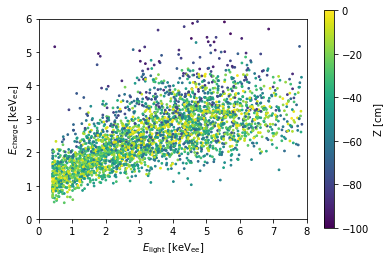

In [23]:
def scatter_energy(df, s=3, cbar=True, **kwargs):
    plt.scatter(df['e_light_vis'], df['e_charge_vis'], 
                c=df['z'], vmin=-100, vmax=0,
                s=s)
    plt.xlabel(r"$E_\mathrm{light}$ [$\mathrm{keV}_\mathrm{ee}$]")
    plt.xlim(0, 8)
    plt.ylabel(r"$E_\mathrm{charge}$ [$\mathrm{keV}_\mathrm{ee}$]")
    plt.ylim(0, 6)
    plt.gca().set_aspect('equal')
    if cbar:
        plt.colorbar(label='Z [cm]', **kwargs)
    
scatter_energy(df)

However, there is still a $z$-dependent effect: the fluctuation in E_charge is much larger in the bottom of the TPC than the bottom. You can see this more clearly if we split out the different z's:

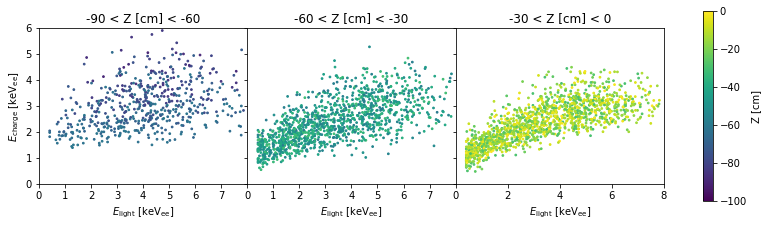

In [24]:
f, axes = plt.subplots(1, 3, figsize=(14, 3.5), sharey=True)
plt.subplots_adjust(wspace=0)
for i, z_slice in enumerate([(-90, -60), (-60, -30), (-30, 0)]):
    plt.sca(axes[i])
    scatter_energy(df[(z_slice[0] < df['z']) & (df['z'] < z_slice[1])],
                   cbar=i == 2, ax=axes)
    plt.title("%d < Z [cm] < %d" % z_slice)
    if i != 0:
        plt.ylabel("")
    if i != 2:
        plt.xticks(plt.xticks()[0][:-1])


The cause is simply a statistical effect: because the S2s in the bottom of the smaller, E_charge has a larger relative fluctuation. This means ER/NR discrimination at the bottom of the TPC will be worse than at the top.

The g1/g2 correction accounts for the mean position-dependence, but still loses information. This is one of the reasons that higher-dimensional likelihoods can provide a gain in sensitivity.